# Apacheのアクセスログ解析

必要なライブラリーのインポート

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

# グラフなどはNotebook内に描画
%matplotlib inline

# DataFrameの列の最大文字列長をデフォルトの50から150に変更
pd.set_option("display.max_colwidth", 150)

アクセスログのロードに必要な型解析用の関数を定義

In [2]:
from datetime import datetime
import pytz

def parse_str(x):
    return x[1:-1]

def parse_datetime(x):
    dt = datetime.strptime(x[1:-7], '%d/%b/%Y:%H:%M:%S')
    dt_tz = int(x[-6:-3])*60+int(x[-3:-1])
    return dt.replace(tzinfo=pytz.FixedOffset(dt_tz))

円グラフなどに表示する際の少数の要素（1%以下の割合のもの）を「others」（その他）に変換する関数を定義

In [3]:
# DataFrame用
def replace_df_minors_with_others(df_before, column_name):
    elm_num = 1
    for index, row in df_before.sort_values([column_name], ascending=False).iterrows():
        if (row[column_name] / df_before[column_name].sum()) > 0.01:
            elm_num = elm_num + 1
    
    df_after = df_before.sort_values([column_name], ascending=False).nlargest(elm_num, columns=column_name)
    df_after.loc[len(df_after)] = ['others', df_before.drop(df_after.index)[column_name].sum()]
    return df_after

# 辞書用
def replace_dict_minors_with_others(dict_before):
    dict_after = {}
    others = 0
    total = sum(dict_before.values())
    for key in dict_before.keys():
        if (dict_before.get(key) / total) > 0.01:
            dict_after[key] = dict_before.get(key)
        else:
            others = others + dict_before.get(key)
    dict_after = {k: v for k, v in sorted(dict_after.items(), reverse=True, key=lambda item: item[1])}
    dict_after['others'] = others
    return dict_after

アクセスログのロード

In [4]:
access_log_path = 'access.log'

df = pd.read_csv(
    access_log_path,
    sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
    engine='python',
    na_values='-',
    header=None,
    usecols=[0, 4, 6, 7, 8, 9, 10],
    names=['ip', 'time', 'response_time', 'request', 'status', 'size', 'user_agent'],
    converters={'time': parse_datetime,
                'response_time': int,
                'request': parse_str,
                'status': int,
                'size': int,
                'user_agent': parse_str})

先頭10行を確認

In [5]:
df

,ip,time,response_time,request,status,size,user_agent
0,192.168.1.142,2020-03-24 18:20:00+09:00,7746,POST /openam/policyservice HTTP/1.1,200,2523,Java/1.8.0_131
1,192.168.1.142,2020-03-24 18:20:00+09:00,7451,POST /openam/policyservice HTTP/1.1,200,2523,Java/1.8.0_131
2,192.168.1.142,2020-03-24 18:20:00+09:00,6074,POST /openam/policyservice HTTP/1.1,200,2523,Java/1.8.0_131
3,192.168.1.142,2020-03-24 18:20:01+09:00,5647,POST /openam/policyservice HTTP/1.1,200,2523,Java/1.8.0_131
4,192.168.1.142,2020-03-24 18:20:01+09:00,6109,POST /openam/policyservice HTTP/1.1,200,2523,Java/1.8.0_131
...,...,...,...,...,...,...,...
114000,192.168.1.18,2020-03-24 19:40:59+09:00,8007,GET /openam/cdcservlet?goto=https%3A%2F%2Fsso-web.example.co.jp%3A443%2Fdirect%2Fimages%2Ffavicon.ico&RequestID=309604242&MajorVersion=1&MinorVers...,200,17195,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko
114001,192.168.1.5,2020-03-24 19:40:59+09:00,413824,POST /openam/UI/Login HTTP/1.1,302,NaN,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36"
114002,192.168.1.18,2020-03-24 19:40:59+09:00,54970,GET /app3/pid HTTP/1.1,200,345,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko
114003,192.168.1.5,2020-03-24 19:40:59+09:00,7298,GET /openam/cdcservlet?loginURI=config/auth/default/Login_app1.jsp&goto=https%3A%2F%2Fwww.app1.jp%3A443%2Fapp1%2Fredirect.do&RequestID=309604242&M...,200,3835,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36"


In [6]:
df.isnull().sum()

ip                   0
time                 0
response_time        0
request              0
status               0
size              9591
user_agent       31875
dtype: int64

応答時間の平均値や最大値を表示する

In [7]:
print('応答時間の集計結果（マイクロ秒）\n')
print('最小値 : {}'.format(str(df['response_time'].min()).rjust(10)))
print('平均値 : {}'.format(str(round(df['response_time'].mean())).rjust(10)))
print('中央値 : {}'.format(str(round(df['response_time'].median())).rjust(10)))
print('最大値 : {}'.format(str(df['response_time'].max()).rjust(10)))

print('\n応答時間のワースト15')
df.sort_values('response_time', ascending=False).head(15)

応答時間の集計結果（マイクロ秒）

最小値 :         71
平均値 :     104997
中央値 :       5700
最大値 :   15489661

応答時間のワースト15


,ip,time,response_time,request,status,size,user_agent
43093,192.168.1.142,2020-03-24 18:58:58+09:00,15489661,POST /openam/authservice HTTP/1.0,406,NaN,NaN
30221,192.168.1.142,2020-03-24 18:50:48+09:00,14859580,POST /openam/authservice HTTP/1.0,406,NaN,NaN
54128,192.168.1.142,2020-03-24 19:05:27+09:00,14802030,POST /openam/authservice HTTP/1.0,406,NaN,NaN
30238,192.168.1.142,2020-03-24 18:50:48+09:00,14793976,POST /openam/authservice HTTP/1.0,406,NaN,NaN
36150,192.168.1.142,2020-03-24 18:54:50+09:00,14766933,POST /openam/authservice HTTP/1.0,406,NaN,NaN
54142,192.168.1.142,2020-03-24 19:05:28+09:00,14738199,POST /openam/authservice HTTP/1.0,406,NaN,NaN
23985,192.168.1.142,2020-03-24 18:45:54+09:00,14725243,POST /openam/authservice HTTP/1.0,406,NaN,NaN
36163,192.168.1.142,2020-03-24 18:54:50+09:00,14721547,POST /openam/authservice HTTP/1.0,406,NaN,NaN
54171,192.168.1.142,2020-03-24 19:05:30+09:00,14657677,POST /openam/authservice HTTP/1.0,406,NaN,NaN
37272,192.168.1.142,2020-03-24 18:55:32+09:00,14656985,POST /openam/authservice HTTP/1.0,406,NaN,NaN


In [8]:
ua_df = DataFrame(df.groupby(['user_agent']).size().index)
ua_df['count'] = df.groupby(['user_agent']).size().values
ua_df

,user_agent,count
0,AWS Security Scanner,3
1,Apache CXF 3.0.8,214
2,Apache-CXF/3.1.10,6
3,Apache-HttpClient/4.5 (Java/1.8.0_201),1
4,Apache-HttpClient/4.5.1 (Java/1.8.0_171),26
...,...,...
485,Zabbix,2
486,"\""Mozilla/5.",2
487,curl/7.65.1,1
488,python-requests/2.10.0,1


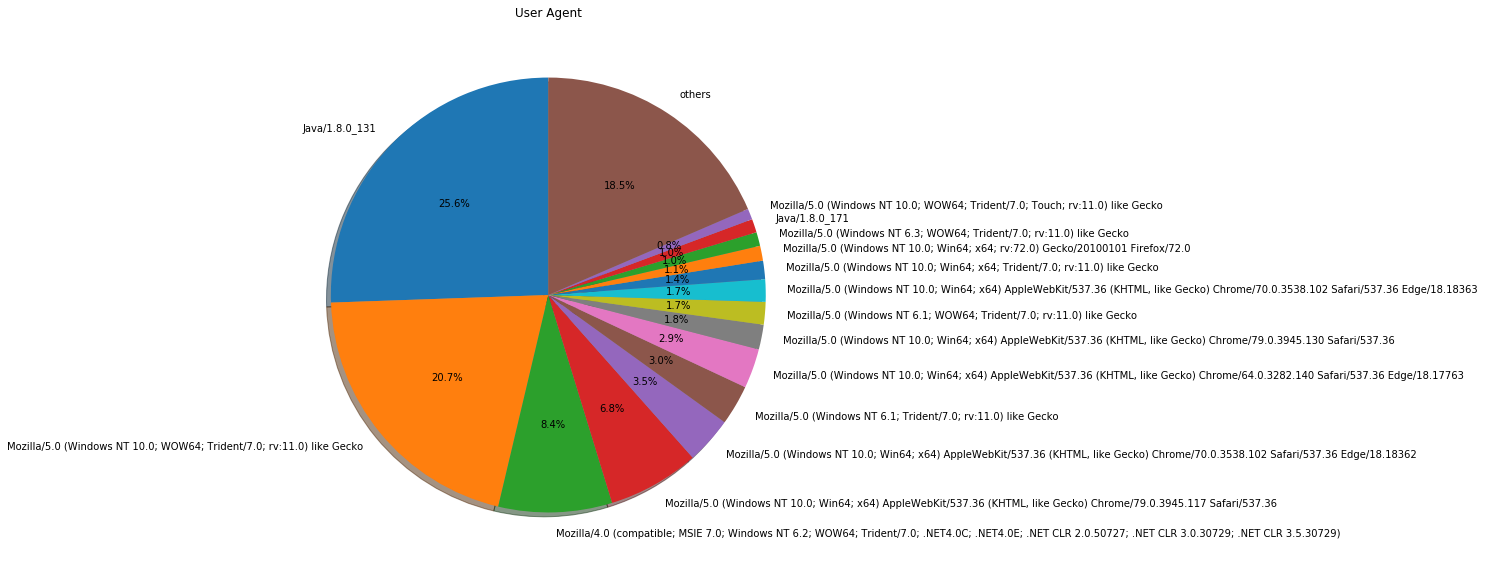

In [9]:
plt.figure(figsize = (15, 10))
ua_df_with_others = replace_df_minors_with_others(ua_df, 'count')
plt.pie(ua_df_with_others['count'], labels = ua_df_with_others['user_agent'], autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.title('User Agent')
plt.show()

In [10]:
replace_df_minors_with_others(ua_df, 'count')

,user_agent,count
83,Java/1.8.0_131,20989
294,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko,17035
152,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.2; WOW64; Trident/7.0; .NET4.0C; .NET4.0E; .NET CLR 2.0.50727; .NET CLR 3.0.30729; .NET CLR 3.5.30...,6935
319,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36",5595
307,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18362",2876
360,Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko,2442
305,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.140 Safari/537.36 Edge/18.17763",2418
320,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36",1512
372,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko,1381
308,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363",1370


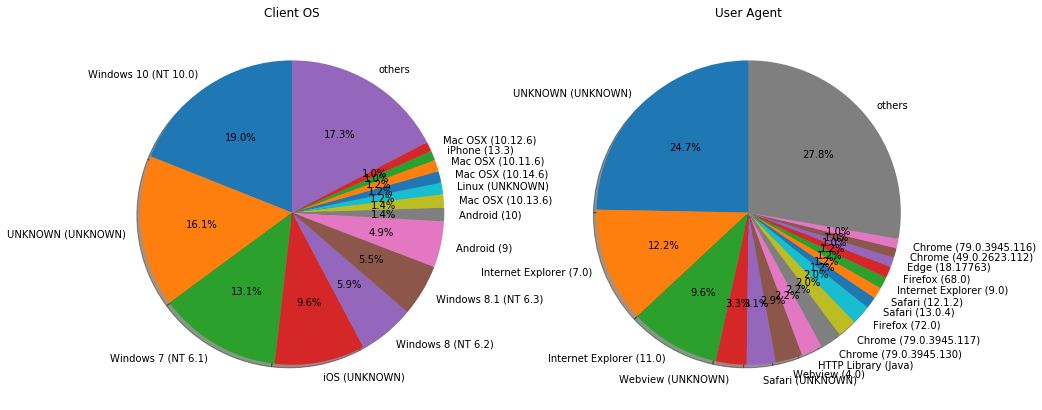

In [11]:
import woothee

ua_counter = {}
os_counter = {}

for index, row in ua_df.sort_values(['count'], ascending=False).iterrows():
    
    ua = woothee.parse(row['user_agent'])
    
    uaKey = ua.get('name') + ' (' + ua.get('version') + ')'
    if not uaKey in ua_counter:
        ua_counter[uaKey] = 0
    ua_counter[uaKey] = ua_counter[uaKey] + 1
    
    osKey = ua.get('os') + ' (' + ua.get('os_version') + ')'
    if not osKey in os_counter:
        os_counter[osKey] = 0
    os_counter[osKey] = os_counter[osKey] + 1

plt.figure(figsize = (15, 10))
plt.subplot(1,2,1)
plt.title('Client OS')
os_counter_with_others = replace_dict_minors_with_others(os_counter)
plt.pie(os_counter_with_others.values(), labels = os_counter_with_others.keys(), autopct = '%1.1f%%', shadow = True, startangle = 90)

plt.subplot(1,2,2)
plt.title('User Agent')
ua_counter_with_others = replace_dict_minors_with_others(ua_counter)
plt.pie(ua_counter_with_others.values(), labels = ua_counter_with_others.keys(), autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.show()

HTTPステータス別のリクエスト件数とその割合

In [12]:
status_df = DataFrame(df.groupby(['status']).size().index)
status_df['count'] = df.groupby(['status']).size().values
status_df['percentage'] = (df.groupby(['status']).size() / len(df) * 100).values
status_df

,status,count,percentage
0,200,104530,91.688961
1,204,56,0.049121
2,206,19,0.016666
3,301,503,0.441209
4,302,3555,3.118284
5,304,4289,3.762116
6,400,73,0.064032
7,401,12,0.010526
8,403,4,0.003509
9,404,74,0.064909


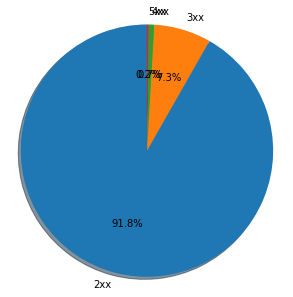

In [13]:
# グラフの大きさ指定
plt.figure(figsize = (5, 5))

labels = ['2xx', '3xx', '4xx', '5xx']

# グラフを表示
plt.pie(df.groupby([df['status'] // 100]).size(), autopct = '%1.1f%%', labels = labels, shadow = True, startangle = 90)

# 円を丸く描画
plt.axis('equal')

df.groupby([df['status'] // 100]).size()
plt.show()

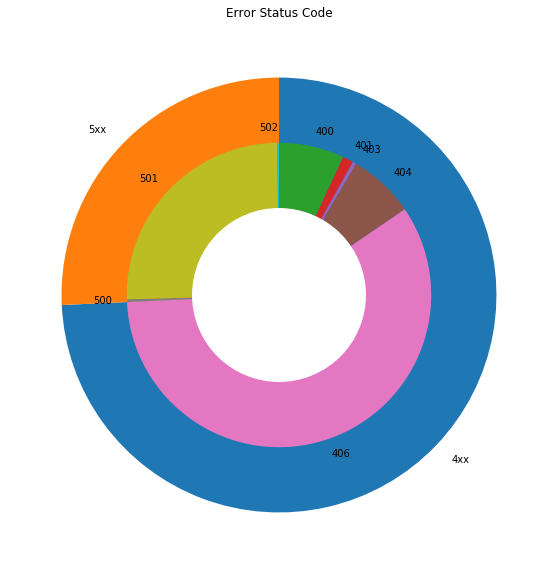

In [14]:
error_df = df[df['status'] >= 400]

plt.figure(figsize = (10, 10))

labels = ['4xx', '5xx']

plt.pie(error_df.groupby([error_df['status'] // 100]).count().time, labels=labels, counterclock=False, startangle=90)

labels2 = ['400', '401', '403', '404', '406', '500', '501', '502']

# 円グラフ (内側, 半径 70% で描画)
plt.pie(error_df.groupby(['status']).count().time, labels=labels2, counterclock=False, startangle=90, radius=0.7)
 
# 中心 (0,0) に 40% の大きさで円を描画
centre_circle = plt.Circle((0,0),0.4, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Error Status Code')
plt.show()

負荷の状況を確認

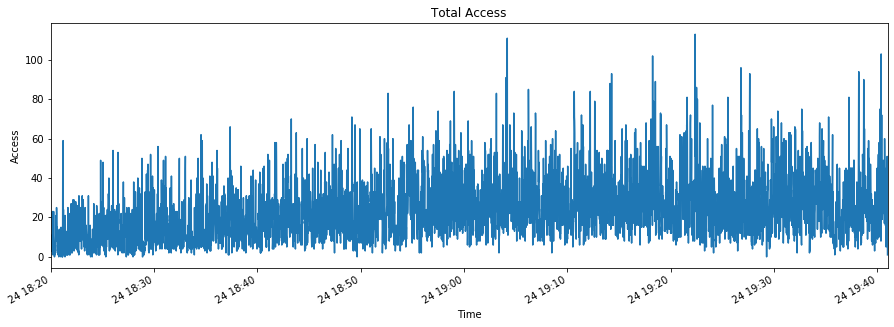

In [15]:
plt.figure(figsize = (15, 5))
access = df['request']
access.index = df['time']
access = access.resample('S').count()
access.index.name = 'Time'
access.plot()
plt.title('Total Access')
plt.ylabel('Access')
plt.show()

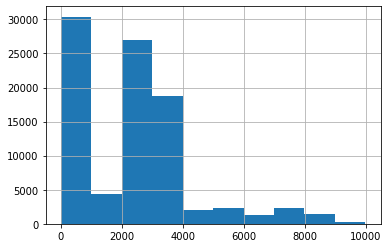

In [16]:
df[df['size']<10000]['size'].hist();

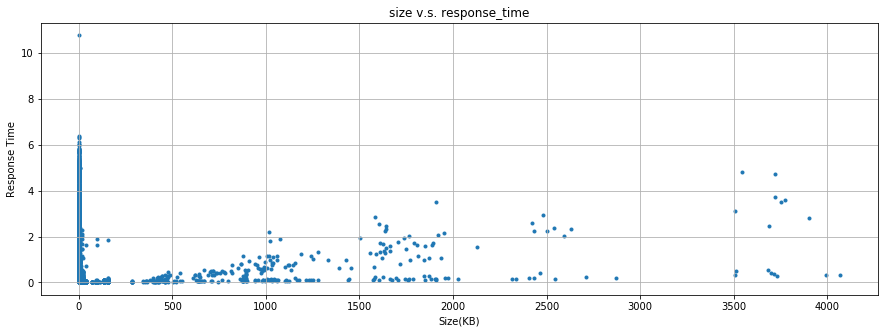

In [17]:
plt.figure(figsize = (15, 5))
plt.title('size v.s. response_time')
plt.scatter(df['size']/1000, df['response_time']/1000000, marker='.')
plt.xlabel('Size(KB)')
plt.ylabel('Response Time')
plt.grid()